# ALeRCE API retrieval examples

Load libraries

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os, sys

import requests
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import pandas as pd
import seaborn as sns
#from pandas.io.json import json_normalize

#from collections import OrderedDict

from astropy.time import Time
from datetime import datetime
from IPython.display import HTML

import astropy.units as u
from astropy import coordinates

#from astroquery.ned import Ned
#from astroquery.simbad import Simbad
#from astropy.time import Time

#import json

from alerce.api import AlerceAPI

#!pip install psycopg2-binary
import psycopg2

from io import StringIO

/home/rodrigo/anaconda3/envs/tf1/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import time
from astropy.time import Time

In [4]:
now = Time(datetime.utcnow(), scale='utc').datetime
now_mjd = Time(datetime.utcnow(), scale='utc').mjd

# Get fresh list of SNe sent to TNS by ZTF

In [5]:
def dourl(searchweb, searchoptions):
    url = searchweb
    for key in searchoptions.keys():
        url = "%s&%s=%s" % (url, key, searchoptions[key])
    return url

In [6]:
def get_tns_df(searchoptions):
    urlpage = dourl(searchweb,searchoptions)
    print(urlpage)
    s = requests.Session()
    response = s.get(urlpage)
    response.close()
    df = pd.read_csv(StringIO(response.text))
    urls = [f"http://alerce.online/object/{oid}" for oid in df['Disc. Internal Name']]
    df['url'] = urls
    return df

In [7]:
searchweb = "https://wis-tns.weizmann.ac.il/search?"
searchoptions = {
    "reporting_groupid[]": 48, # ALeRCE 48 ZTF
    #"groupid": 74,
    #"discovery_data_source_id" : "48", # ZTF
    "num_page" : 500,  # 500 number of rows per page
    "format" : "csv",
    "display[remarks]":1,
}

In [ ]:
all_alerce = []
page = 0
while True:
    print("Loading TNS page %i..." % page)
    searchoptions["page"] = page
    temp = get_tns_df(searchoptions)
    all_alerce.append(temp)
    if temp.shape[0] < 500:
        break
    page += 1
all_alerce = pd.concat(all_alerce)

Loading TNS page 0...
https://wis-tns.weizmann.ac.il/search?&reporting_groupid[]=48&num_page=500&format=csv&display[remarks]=1&page=0
Loading TNS page 1...
https://wis-tns.weizmann.ac.il/search?&reporting_groupid[]=48&num_page=500&format=csv&display[remarks]=1&page=1
Loading TNS page 2...
https://wis-tns.weizmann.ac.il/search?&reporting_groupid[]=48&num_page=500&format=csv&display[remarks]=1&page=2
Loading TNS page 3...
https://wis-tns.weizmann.ac.il/search?&reporting_groupid[]=48&num_page=500&format=csv&display[remarks]=1&page=3
Loading TNS page 4...
https://wis-tns.weizmann.ac.il/search?&reporting_groupid[]=48&num_page=500&format=csv&display[remarks]=1&page=4
Loading TNS page 5...
https://wis-tns.weizmann.ac.il/search?&reporting_groupid[]=48&num_page=500&format=csv&display[remarks]=1&page=5
Loading TNS page 6...
https://wis-tns.weizmann.ac.il/search?&reporting_groupid[]=48&num_page=500&format=csv&display[remarks]=1&page=6
Loading TNS page 7...
https://wis-tns.weizmann.ac.il/search?&r

In [ ]:
all_alerce.shape

In [ ]:
all_alerce.head()

In [ ]:
all_alerce.columns

In [ ]:
sent = list(all_alerce["Disc. Internal Name"].values)

In [ ]:
retracted = pd.read_csv("retracted.txt").oid.to_list()

### Remove retracted

In [ ]:
all_alerce = all_alerce[~all_alerce["Disc. Internal Name"].isin(retracted)]

In [ ]:
all_alerce.to_pickle("all_ztf.pkl")


In [ ]:
all_alerce = pd.read_pickle("all_ztf.pkl")
retracted = pd.read_csv("retracted.txt").oid.to_list()
sent = list(all_alerce["Disc. Internal Name"].values)

In [ ]:
classified_mask = ~(all_alerce["Classifying Group/s"].isna())

In [ ]:
np.sum(classified_mask)

In [ ]:
all_alerce.iloc[0]["Name"].split(" ")[-1]

# all_alerce[classified_mask]["Obj. Type"].value_counts()


In [ ]:
df_SN = all_alerce[classified_mask]["Obj. Type"].value_counts()
print(df_SN)
df_SN.plot.pie(y="count", figsize=(5, 5))
plt.axis("off")
plt.legend()

In [ ]:
all_alerce.loc[classified_mask][(all_alerce[classified_mask]["Obj. Type"] == 'SN IIb')]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
#sns.set(style="darkgrid")
counts = all_alerce[classified_mask]["Obj. Type"].value_counts()
sns.countplot(ax=ax, y="Obj. Type", data=all_alerce[classified_mask], order=counts.index)#cl[n.argsort()[::-1]])
ax.set_title("Spectroscopically classified SNe discovered by ZTF (%i), %s/%02i/%02i" % 
             (classified_mask.sum(), now.year, now.month, now.day), fontsize=14)
#ax.axvline(2.5, c = 'gray')
plt.tight_layout()
plt.savefig("ztf_plots/SN_types.png")

In [ ]:
classified_oids = all_alerce[classified_mask]["Disc. Internal Name"].tolist()

In [ ]:
oids = [oid for oid in sent if oid not in retracted]
oids = np.array(oids, dtype = str)

# Optional, use all SNe found, not just those in TNS

In [ ]:
mode="tns" #'tns' 'all'
if mode == "all":
    oids = []
    for file in os.listdir("candidates"):
        if file[-3:] == 'txt':
            for oid in open("candidates/%s" % file, 'r').readlines():
                oids.append(oid[:-1])
    oids = np.array(oids)
    oids = np.unique(oids)
    oids = [oid for oid in oids if oid not in retracted]
    oids = np.array(oids, dtype = str)
elif mode=="tns":
    oids = [oid for oid in sent if oid not in retracted]
    oids = np.array(oids, dtype = str)

# Run all these cells if you want to update the results

In [ ]:
alerce = AlerceAPI()

In [ ]:
import json
credentials_file = "../usecases/alercereaduser_v2.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

In [ ]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

In [ ]:
query = "select tablename from pg_tables where schemaname='public';"
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="tablename")

In [ ]:
alltabs = []
for tab in sorted(tables.tablename):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

In [ ]:
query='''
select objects.oid, objects.firstmjd, objects.nobs, objects.meanra, objects.meandec
from objects
where objects.oid in (%s)
''' % ",".join(["'%s'" % oid for oid in oids])
SNe = pd.read_sql_query(query, conn)
SNe.set_index('oid', inplace=True)
SNe.head()

In [ ]:
query='''
select oid, candid, mjd, fid, magpsf, sigmapsf, magpsf_corr, sigmapsf_corr
from detections
where detections.oid in (%s)
''' % ",".join(["'%s'" % oid for oid in oids])
all_detections = pd.read_sql_query(query, conn)
all_detections.set_index('candid', inplace=True)
all_detections.head()

In [ ]:
query='''
select oid, fid, diffmaglim, mjd
from non_detections
where non_detections.oid in (%s)
''' % ",".join(["'%s'" % oid for oid in oids])
all_non_detections = pd.read_sql_query(query, conn)
all_non_detections.set_index('mjd', inplace=True)
all_non_detections.head()

# Histogram of cadences

In [ ]:
dts = []
dts_1st = []
dts_fid = []
for oid in all_detections.oid.unique():
    mask = (all_detections.oid == oid)
    times = np.sort(np.array(all_detections.loc[mask].mjd.unique()))
    if mask.sum() > 1:
        dts.append(times[1:] - times[:-1])
        dts_1st.append([times[1] - times[0]])
    for fid in [1, 2]:
        mask = (all_detections.oid == oid) & (all_detections.fid == fid)
        times = np.sort(np.array(all_detections.loc[mask].mjd.unique()))
        if mask.sum() > 1:
            dts_fid.append(times[1:] - times[:-1])
dts = np.concatenate(dts)
dts_1st = np.concatenate(dts_1st)
dts_fid = np.concatenate(dts_fid)

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(dts_1st, bins=1000, cumulative=True, density=True);
ax.set_xlim(0, 20)
ax.set_xlabel("Confirmation time (any band)", fontsize=16)
ax.set_ylabel("CDF", fontsize=16)
ax.set_title("SN time between first and second obs.", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("ztf_plots/SNconfirmation_any_%s.png" % mode)

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(dts, bins=1000, cumulative=True, density=True);
ax.set_xlim(0, 20)
ax.set_xlabel("Cadence distribution (any band)", fontsize=16)
ax.set_ylabel("CDF", fontsize=16)
ax.set_title("SN light curve cadences", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("ztf_plots/SNcadence_any_%s.png" % mode)

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(dts_fid, bins=1000, cumulative=True, density=True);
ax.set_xlim(0, 20)
ax.set_xlabel("Cadence distribution (same band)", fontsize=16)
ax.set_ylabel("CDF", fontsize=16)
ax.set_title("SN light curve cadences", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("ztf_plots/SNcadence_same_%s.png" % mode)

# Extract relevant features

In [ ]:
nobs = []
dts = []
dt2s = []
dmags = []
dts_fid = []
dmags_fid = []
dmdt_fid = []
first_mjds = []
first_det_mags = []
max_mags = []
max_mjds = []
dt_first_max = []
dmag_first_max = []
ras = []; decs = []
reporting_date = []
reporting_time = []

ids_to_drop = []

for SN in oids:#["ZTF19abpsana"]:
    if SN in SNe.index:
        stats = SNe.loc[SN]
    else:
        print("#### skipping SN ####")
        ids_to_drop.append(SN)
        continue
    stats.dropna(inplace=True)
    detections = all_detections[all_detections.oid == SN]
    non_detections = all_non_detections[all_non_detections.oid == SN]
    try:
        nobs.append(int(stats.nobs))
    except:
        print("#### no stats ####")
        print(stats)
        ids_to_drop.append(SN)
        continue
    
    first_det_idx = detections.mjd.idxmin()
    first_det_mjd = float(detections.loc[first_det_idx].mjd)
    first_det_fid = int(detections.loc[first_det_idx].fid)
    first_det_mag = float(detections.loc[first_det_idx].magpsf)
    first_det_mags.append(first_det_mag)
    ras.append(stats.meanra)
    decs.append(stats.meandec)
    first_mjds.append(first_det_mjd)
    max_mjds.append(detections.loc[detections.magpsf.idxmin()].mjd)
    max_mags.append(detections.loc[detections.magpsf.idxmin()].magpsf)
    dt_first_max.append(max_mjds[-1] - first_mjds[-1])
    dmag_first_max.append(first_det_mags[-1] - max_mags[-1])
    
    mask = non_detections.index < first_det_mjd
    if np.sum(mask) > 0:
        last_non_det_mjd = np.array(non_detections.index[mask]).max()
        last_non_det_mag = non_detections.loc[last_non_det_mjd].diffmaglim
        if last_non_det_mag.shape != ():
            last_non_det_mag = last_non_det_mag.unique()[0]
        dts.append(first_det_mjd - last_non_det_mjd)
        dmags.append(last_non_det_mag - first_det_mag)
    else:
        dts.append(None)
        dmags.append(None)

    mask = (non_detections.index < first_det_mjd) & (non_detections.fid == first_det_fid)
    if np.sum(mask) > 0:
        last_non_det_fid_mjd = non_detections.index[mask].max()
        last_non_det_fid_mag = non_detections.loc[last_non_det_fid_mjd].diffmaglim
        if last_non_det_fid_mag.shape != ():
            last_non_det_fid_mag = last_non_det_fid_mag.unique()[0]
        dts_fid.append(first_det_mjd - last_non_det_fid_mjd)
        dmags_fid.append(last_non_det_fid_mag - first_det_mag)
        dmdt_fid.append(dmags_fid[-1] / dts_fid[-1])
    else:
        dts_fid.append(None)
        dmags_fid.append(None)
        dmdt_fid.append(None)
    
    if nobs[-1] > 1:
        second_det_mjd = detections.mjd[detections.mjd > first_det_mjd].min()
        dt2s.append(second_det_mjd - last_non_det_mjd)
    else: 
        dt2s.append(None)
        
    print(SN, nobs[-1], dts[-1], dt2s[-1], dmags[-1], dmags_fid[-1], dt_first_max[-1])
    

In [ ]:
new_oids = []
for oi in oids:
    if oi in ids_to_drop:
        continue
    else:
        new_oids.append(oi)

oids = new_oids
len(oids), len(nobs), len(dts), len(dt2s), len(dmags), len(dts_fid), len(dmags_fid), len(first_mjds), len(dt_first_max), len(ids_to_drop)

In [ ]:
df = {'oid': oids, 'nobs': nobs, 'dt': dts, 'dt2': dt2s, 'dmag': dmags, 'dt_fid': dts_fid, 
      'dmag_fid': dmags_fid, 'first_mjd': first_mjds, 'first_det_mag': first_det_mags, 
      'ra': ras, 'dec': decs, 'dt_first_max': dt_first_max, 'dmag_first_max': dmag_first_max,
      'mag_at_max': max_mags, 'dmdt_fid': dmdt_fid}
df = pd.DataFrame(df)
df.head()

In [ ]:
df.to_pickle("ztf_summary_%s.pkl" % mode)

# Start from here if you want to use available results

In [ ]:
mode = 'tns' #'tns'
df = pd.read_pickle("ztf_summary_%s.pkl" % mode)
df.set_index("oid", inplace=True)
df.head()

### Histogram of UT times of first detection

In [ ]:
df["first_UT"] = df.apply(lambda row: float(Time(row["first_mjd"], format='mjd').datetime.hour) + float(Time(row["first_mjd"], format='mjd').datetime.minute) / 60., axis=1)

In [ ]:
df

In [ ]:
fig, ax = plt.subplots()
ax.hist(df.first_UT[df.first_UT < df.dt2], bins=20, alpha=0.3)
ax.hist(df.first_UT[df.first_UT >= df.dt2], bins=20, alpha=0.3)

In [ ]:
fig, ax = plt.subplots()
ax.hist(df.first_UT, bins=20)
ax.set_xlabel("Discovery UT [hr]", fontsize=16)
ax.set_ylabel("N", fontsize=16)
if mode=="tns":
    ax.set_title("SNe reported by ALeRCE to TNS, %i/%02i/%02i" % 
                 (now.year, now.month, now.day), fontsize = 16)
elif mode=="all":
    ax.set_title("SNe identified by ALeRCE, %i/%02i/%02i" % 
                 (now.year, now.month, now.day), fontsize = 16)
plt.savefig("ztf_plots/discovery_UT.png")

print(np.mean(df.first_UT), np.std(df.first_UT))

### Histogram of RA DEC coordinates

In [ ]:
import ephem

In [ ]:
df["ecl_lat"] = df.apply(lambda row: np.rad2deg(ephem.Ecliptic(ephem.Equatorial('%s' % (row.ra / 15.), '%s' % row.dec, epoch=ephem.J2000)).lat), axis=1)

In [ ]:
fig, ax = plt.subplots()
mask = df.nobs == 1
ax.hist(df.ecl_lat[mask], bins=30, label="1 det.", alpha=0.5, density=True)
ax.hist(df.ecl_lat[~mask], bins=30, label=">1 det.", alpha=0.5, density=True)
ax.legend()
ax.set_xlabel("Ecliptic latitude [deg]", fontsize=16)
ax.set_ylabel("N", fontsize=16)
if mode=="tns":
    ax.set_title("SNe reported by ALeRCE to TNS, %i/%02i/%02i" % 
                 (now.year, now.month, now.day), fontsize = 16)
elif mode=="all":
    ax.set_title("SNe identified by ALeRCE, %i/%02i/%02i" % 
                 (now.year, now.month, now.day), fontsize = 16)
plt.savefig("ztf_plots/discovery_ecl_lat.png")


### Cumulative distribution of MJD times

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
x, y, _ = ax.hist(df.first_mjd, bins = np.linspace(df.first_mjd.min(), df.first_mjd.max(), df.first_mjd.max() - df.first_mjd.min() + 1), cumulative = True, label="1 detection")
ax.set_xlabel("Detection time [MJD]", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("Cumulative number of reported SNe", fontsize = 16)
if mode=="tns":
    ax.set_title("SNe reported by ALeRCE to TNS (average %.1f SN/day), %i/%02i/%02i" % 
                 (len(oids) / (df.first_mjd.max() - df.first_mjd.min()), now.year, now.month, now.day), fontsize = 16)
elif mode=="all":
    ax.set_title("SNe identified by ALeRCE (average %.1f SN/day), %i/%02i/%02i" % 
                 (df.shape[0] / (df.first_mjd.max() - df.first_mjd.min()), now.year, now.month, now.day), fontsize = 16)
ax.set_title("")
print("SNe identified by ALeRCE (average %.1f SN/day), %i/%02i/%02i" % 
                 (df.shape[0] / (df.first_mjd.max() - df.first_mjd.min()), now.year, now.month, now.day))
efficiency = 0.95
plt.savefig("plots/firstmjd.png")
ax.hist(df[df.nobs > 1].first_mjd, bins = np.linspace(df.first_mjd.min(), df.first_mjd.max(), df.first_mjd.max() - df.first_mjd.min() + 1), cumulative = True, label=">1 detection")
ax.plot((y[:-1] + y[1:]) / 2, x * efficiency, c = 'k', label="%i%% of 1 detection cumulative" % (efficiency * 100.), lw=4)
ax.legend(fontsize=16)
plt.tick_params(labelsize=14)
plt.xlim([df.first_mjd.min(), df.first_mjd.max()])
plt.savefig("ztf_plots/firstmjd_efficiency_%s.png" % mode, bbox_inches="tight")
plt.savefig("ztf_plots/firstmjd_efficiency_%s.pdf" % mode, bbox_inches="tight")

print(len(df.first_mjd))
print(df.first_mjd.min(), df.first_mjd.max())

# Do mosaic of stamps

In [51]:
def plot_stamp(self, oid, candid=None):
    'plot stamp in a notebook given oid. It uses IPython HTML.'

    # if candid is None, get minimum candid                                                                                                                                                                    
    if candid is None:
        candid = min(self.get_detections(oid).index)

    science = "http://avro.alerce.online/get_stamp?oid=%s&candid=%s&type=science&format=png" % (oid, candid)
    images="""                                                                                                                                                                                                 
    <div>ZTF oid: %s, candid: %s</div>                                                                                                                                                                         
    <div>&emsp;&emsp;&emsp;&emsp;&emsp;                                                                                                                                                                        
    Science                                                                                                                                                                                                    
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;                                                                                                                                   
    Template                                                                                                                                                                                                   
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;                                                                                                                                   
    Difference                                                                                                                                                                                                 
    <div class="container">                                                                                                                                                                                    
    <div style="float:left;width:20%%"><img src="%s"></div>                                                                                                                                                    
    <div style="float:left;width:20%%"><img src="%s"></div>                                                                                                                                                    
    <div style="float:left;width:20%%"><img src="%s"></div>                                                                                                                                                    
    </div>                                                                                                                                                                                                     
    """ % (oid, candid, science, science.replace("science", "template"), science.replace("science", "difference"))
    display(HTML(images))


# Distribution of number of detections

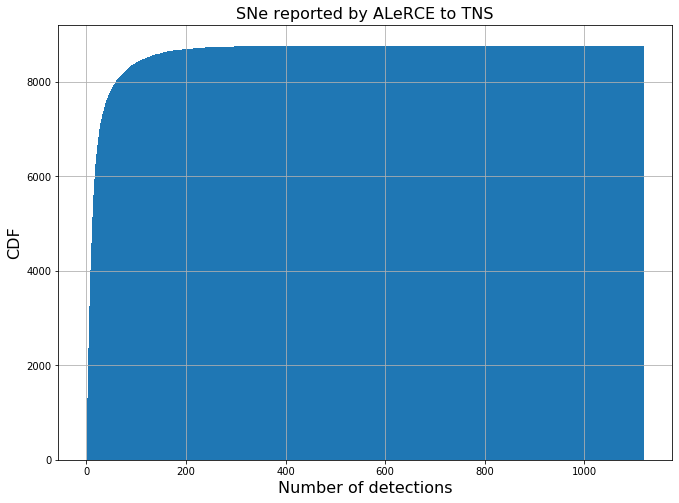

In [52]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.hist(df.nobs, bins = np.linspace(0, df.nobs.max(), df.nobs.max() + 1), cumulative = True)
ax.set_xlabel("Number of detections", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("CDF", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS", fontsize = 16)
plt.savefig("ztf_plots/nobs.png")

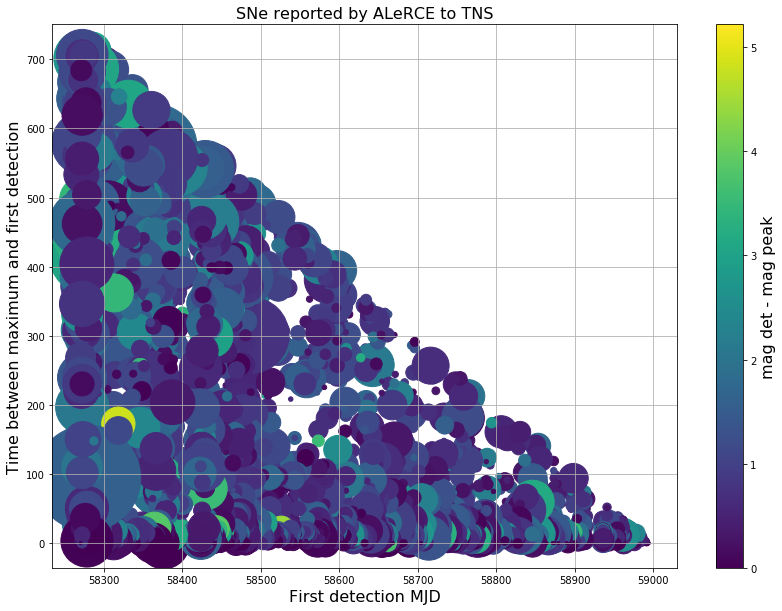

In [53]:
fig, ax = plt.subplots(figsize = (14, 10))
sc = ax.scatter(df.first_mjd, df.dt_first_max, s = 10 * df.nobs, c = df.dmag_first_max)
cbar = fig.colorbar(sc)
cbar.set_label("mag det - mag peak", fontsize=16)
ax.set_xlabel("First detection MJD", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("Time between maximum and first detection", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS", fontsize = 16)
plt.savefig("ztf_plots/dt_first_max_firstMJD.png")

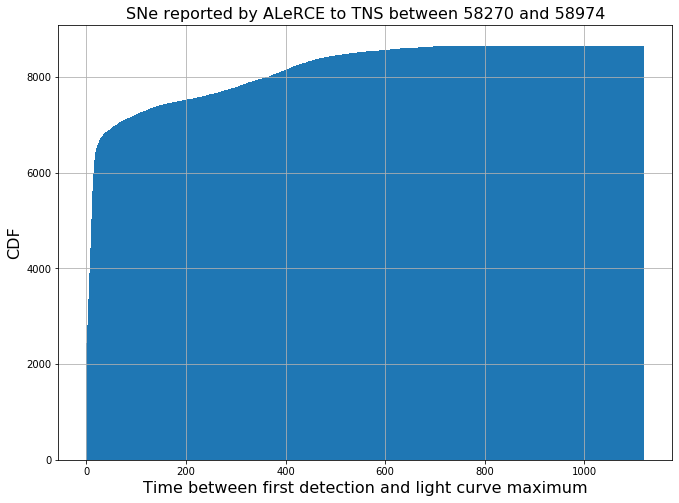

In [54]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.hist(df.dt_first_max[df.first_mjd < df.first_mjd.max() - 20], bins = np.linspace(0, df.nobs.max(), df.nobs.max() + 1), cumulative = True)
ax.set_xlabel("Time between first detection and light curve maximum", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("CDF", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS between %i and %i" % (df.first_mjd.min(), df.first_mjd.max() - 20), fontsize = 16)
plt.savefig("ztf_plots/dt_first_mag.png")

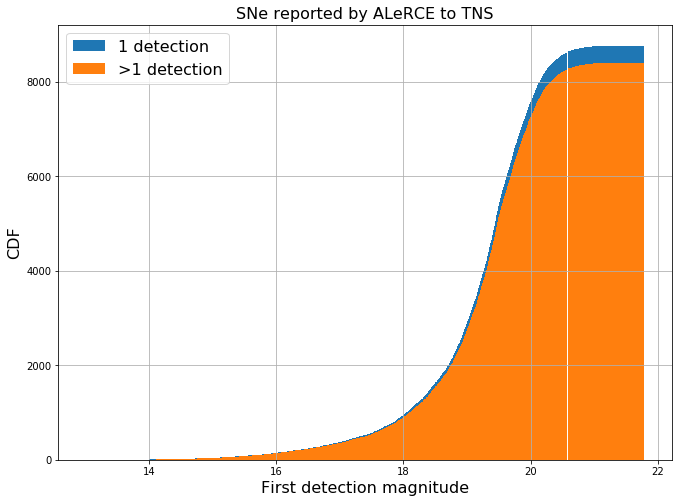

In [55]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.hist(df.first_det_mag, bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1), cumulative = True, label="1 detection")
ax.hist(df[df.nobs > 1].first_det_mag, bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1), cumulative = True, label=">1 detection")
ax.legend(fontsize=16)
ax.set_xlabel("First detection magnitude", fontsize = 16)
ax.grid(which='both')
ax.set_ylabel("CDF", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS", fontsize = 16)
plt.savefig("ztf_plots/mags.png")

8764 SNe reported (excluding 21 retracted)
Average number of detections: 22
Median number of detections: 10
Fraction of candidates with >1 detections: 0.958695
SNe with time between 1st detection and last non-detection < 1 day: 1611
SNe with time between 2nd detection and last non-detection < 1 day: 604
Average time between 1st detection and last non-detection: 4.90 [days]
Average time between 2nd detection and last non-detection: 20.68 [days]
STD time between 2nd detection and last non-detection: 5.06 [days]
STD time between 2nd detection and last non-detection: 64.96 [days]


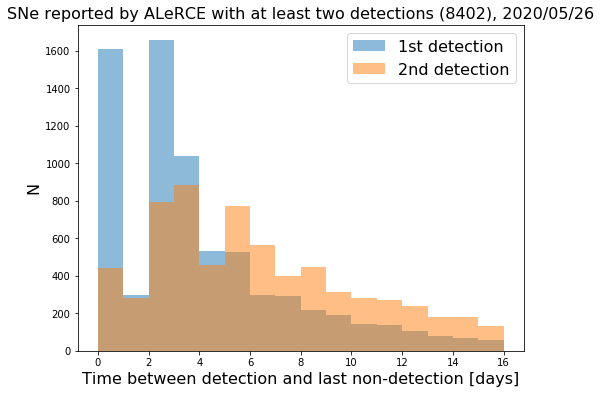

In [56]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.hist(df.dt[df.nobs > 1], alpha = 0.5, bins = np.linspace(0, 16, 17), label = "1st detection" )
ax.hist(df.dt2[df.nobs > 1], alpha = 0.5, bins = np.linspace(0, 16, 17), label = "2nd detection")
ax.set_xlabel("Time between detection and last non-detection [days]", fontsize = 16)
print("%i SNe reported (excluding %i retracted)" % (df.nobs.shape[0], len(retracted)))
print("Average number of detections: %i" % np.average(df.nobs[df.nobs > 1]))
print("Median number of detections: %i" % np.median(df.nobs[df.nobs > 1]))
print("Fraction of candidates with >1 detections: %f" % (np.sum(df.nobs > 1) / df.nobs.shape[0]))
print("SNe with time between 1st detection and last non-detection < 1 day: %i" % np.sum(df.dt[df.nobs > 1] < 1))
print("SNe with time between 2nd detection and last non-detection < 1 day: %i" % np.sum(df.dt2[df.nobs > 1] < 1))
print("Average time between 1st detection and last non-detection: %4.2f [days]" % np.mean(df.dt[df.nobs > 1]))
print("Average time between 2nd detection and last non-detection: %4.2f [days]" % np.mean(df.dt2[df.nobs > 1]))
print("STD time between 2nd detection and last non-detection: %4.2f [days]" % np.std(df.dt[df.nobs > 1]))
print("STD time between 2nd detection and last non-detection: %4.2f [days]" % np.std(df.dt2[df.nobs > 1]))
ax.set_ylabel("N", fontsize = 16)
ax.legend(fontsize = 16)
if mode=="tns":
    ax.set_title("SNe reported by ALeRCE with at least two detections (%i), %i/%02i/%02i" % (np.sum(df.nobs > 1), now.year, now.month, now.day), fontsize = 16)
elif mode=="all":
    ax.set_title("SNe identified by ALeRCE with at least two detections (%i), %i/%02i/%02i" % (np.sum(df.nobs > 1), now.year, now.month, now.day), fontsize = 16)
plt.savefig("ztf_plots/TimeSinceDetection_%s.png" % mode)
plt.savefig("ztf_plots/TimeSinceDetection_%s.pdf" % mode)

[0.885463  4.9995718 0.0420139 ...       nan 2.9934723       nan]
8764 SNe reported (excluding 21 retracted)
Average number of detections: 22
Median number of detections: 10
Fraction of candidates with >1 detections: 0.958695
SNe with time between 1st detection and last non-detection < 1 day: 1611
SNe with time between 2nd detection and last non-detection < 1 day: 604
Average time between 1st detection and last non-detection: 4.90 [days]
Average time between 2nd detection and last non-detection: 20.68 [days]
STD time between 2nd detection and last non-detection: 5.06 [days]
STD time between 2nd detection and last non-detection: 64.96 [days]
Title SNe reported by ALeRCE with at least two detections (8402), 2020/05/26


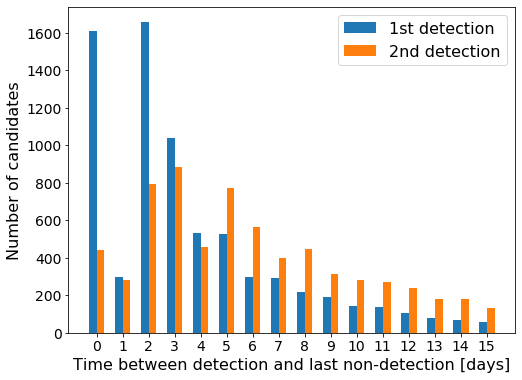

In [57]:
fig, ax = plt.subplots(figsize = (8, 6))
bins = np.linspace(0, 16, 17)
print(df.dt[df.nobs > 1].values)
h1, _ = np.histogram(df.dt[df.nobs > 1].values, bins=bins)
h2, _ = np.histogram(df.dt2[df.nobs > 1].values, bins=bins)
width = 0.3
h1_x = bins - 0.15
h2_x = bins + 0.15
ax.bar(h1_x[0:-1], h1, width=width, label="1st detection")
ax.bar(h2_x[0:-1], h2, width=width, label="2nd detection")
plt.tick_params(labelsize=14)
ax.set_xticks(bins[:-1])

ax.set_xlabel("Time between detection and last non-detection [days]", fontsize = 16)
print("%i SNe reported (excluding %i retracted)" % (df.nobs.shape[0], len(retracted)))
print("Average number of detections: %i" % np.average(df.nobs[df.nobs > 1]))
print("Median number of detections: %i" % np.median(df.nobs[df.nobs > 1]))
print("Fraction of candidates with >1 detections: %f" % (np.sum(df.nobs > 1) / df.nobs.shape[0]))
print("SNe with time between 1st detection and last non-detection < 1 day: %i" % np.sum(df.dt[df.nobs > 1] < 1))
print("SNe with time between 2nd detection and last non-detection < 1 day: %i" % np.sum(df.dt2[df.nobs > 1] < 1))
print("Average time between 1st detection and last non-detection: %4.2f [days]" % np.mean(df.dt[df.nobs > 1]))
print("Average time between 2nd detection and last non-detection: %4.2f [days]" % np.mean(df.dt2[df.nobs > 1]))
print("STD time between 2nd detection and last non-detection: %4.2f [days]" % np.std(df.dt[df.nobs > 1]))
print("STD time between 2nd detection and last non-detection: %4.2f [days]" % np.std(df.dt2[df.nobs > 1]))
ax.set_ylabel("Number of candidates", fontsize = 16)
ax.legend(fontsize = 16)
#if mode=="tns":
#    ax.set_title("SNe reported by ALeRCE with at least two detections (%i), %i/%02i/%02i" % (np.sum(df.nobs > 1), now.year, now.month, now.day), fontsize = 16)
#elif mode=="all":
#    ax.set_title("SNe identified by ALeRCE with at least two detections (%i), %i/%02i/%02i" % (np.sum(df.nobs > 1), now.year, now.month, now.day), fontsize = 16)
print("Title", "SNe reported by ALeRCE with at least two detections (%i), %i/%02i/%02i" % (np.sum(df.nobs > 1), now.year, now.month, now.day))
plt.savefig("ztf_plots/TimeSinceDetection_%s.png" % mode, bbox_inches="tight")
plt.savefig("ztf_plots/TimeSinceDetection_%s.pdf" % mode, bbox_inches="tight")

# Show number of SNe with a lower non-detection in the same filter within the last 25 hr

In [ ]:
fig, ax = plt.subplots(figsize = (11, 8))
lasthr = 25.
mask = (df.dmag_fid.notna())  & (df.dmag_fid > 0.5) & (df.dt_fid <= lasthr / 24.) & (df.nobs > 1)
ax.hist(df.dmag_fid[mask], alpha = 1, bins=10)# cumulative=True)#,
        #label = "%s SNe @ %i/%02i/%02i" % (mask.sum(), now.year, now.month, now.day))#, cumulative=True)
#ax.set_xlabel("Time between detection and last non-detection [days]", fontsize = 16)
#print("%i SNe reported (excluding %i retracted)" % (df.nobs.shape[0], len(retracted)))
#print("Average number of detections: %i" % np.average(df.nobs[df.nobs > 1]))
#print("Median number of detections: %i" % np.median(df.nobs[df.nobs > 1]))
#print("Fraction of candidates with >1 detections: %f" % (np.sum(df.nobs > 1) / df.nobs.shape[0]))
#print("SNe with time between 1st detection and last non-detection < 1 day: %i" % np.sum(df.dt[df.nobs > 1] < 1))
#print("SNe with time between 2nd detection and last non-detection < 1 day: %i" % np.sum(df.dt2[df.nobs > 1] < 1))
#print("Median time between 1st detection and last non-detection: %4.2f [days]" % np.median(df.dt[df.nobs > 1]))
#print("Median time between 2nd detection and last non-detection: %4.2f [days]" % np.median(df.dt2[df.nobs > 1]))
ax.set_xlabel("Last non-detection - detection magnitudes", fontsize = 16)
ax.set_ylabel("N", fontsize = 16)
ax.set_title("SNe with non-detection within last %i hr of 1st detection in the same filter" % (lasthr), fontsize = 16)
#ax.legend(fontsize=16, loc = 1)
plt.savefig("plots/Deltamag.png")
plt.savefig("plots/Deltamag.pdf")
print(df.loc[mask & (df.dmag_fid > 1)].index)


fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(df.dmag_fid[mask], df.first_det_mag[mask], c = df.mag_at_max[mask], s=70)
cbar = fig.colorbar(sc, ticks =[18, 18.5, 19, 19.5, 20])
cbar.set_label('Minimum magnitude', fontsize=16)
cbar.ax.tick_params(which='major',labelsize=16)
ax.set_xlabel("Last non-detection - detection magnitudes", fontsize = 16)
ax.set_ylabel("First detection magnitude", fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("plots/mag_dmag.png")

for oid in mask[mask].index:
    display(HTML("<a href='http://alerce.online/object/%s'> %s <a>" % (oid, oid)))

In [ ]:
mask =  (df.dmdt_fid.notna()) & (df.dmdt_fid > 0.5) & (df.dmdt_fid < 20) & (df.dmag_fid > 0.5)  & (df.nobs>1)
print(mask.sum())

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(df.dmdt_fid[mask], df.first_det_mag[mask], c = df.mag_at_max[mask], s=70)
cbar = fig.colorbar(sc)#, ticks =[17, 17.18, 18.5, 19, 19.5, 20])
cbar.set_label('Minimum magnitude', fontsize=18)
cbar.ax.tick_params(which='major',labelsize=16)
ax.set_xlabel(r"$|\Delta m/ \Delta t|$   [mag/day]", fontsize = 18)
ax.set_ylabel("First detection magnitude", fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.savefig("plots/dmdt.png")

for oid in mask[mask].index:
    display(HTML("<a href='http://alerce.online/object/%s'> %s <a>" % (oid, oid)))

In [ ]:
oid = 'ZTF19abueupg'#'ZTF19abvdgqo'
det = alerce.get_detections(oid, format='pandas')
nondet = alerce.get_non_detections(oid, format='pandas')
fig, ax = plt.subplots(figsize=(8,6))
colors = {1: 'g', 2: 'r'}
mjd0 = det.mjd.min()
for fid in [1, 2]:
    mask = det.fid == fid
    ax.errorbar(det.mjd[mask] - mjd0, det.magpsf[mask], yerr=det.sigmapsf[mask], marker='o', lw=0, elinewidth=1, c=colors[fid], label="%s mag" % colors[fid])
    mask = (nondet.fid == fid) & (nondet.index < det.mjd.min())
    ax.scatter(nondet.index[mask] - mjd0, nondet.diffmaglim[mask], marker='v', c=colors[fid], alpha=0.5, label="mag.lim. %s" % colors[fid])
ax.set_ylim(ax.get_ylim()[1], 18.3)
ax.set_xlim(-10, 20)
ax.tick_params(axis='both', which='major', labelsize=16)
#ax.tick_params(axis='y', which='major', labelsize=16)
ax.set_xlabel("Time since first detection [days]", fontsize=18)
ax.set_ylabel("mag", fontsize=18)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=16, loc=4)
plt.tight_layout()
plt.savefig("BestSN.png")

# Find distribution of time between detection and 5th detection in the same band

In [ ]:
mask = (df.nobs > 5)
dt_5th = {}
for oid in df[mask].index:
    mask = all_detections.oid == oid
    for fid in all_detections[mask].fid.unique():
        mask = (all_detections.oid == oid) & (all_detections.fid == fid)
        if mask.sum() == 0:
            continue
        fid_mjds = all_detections[mask].mjd.values
        if len(fid_mjds) > 4:
            if oid in dt_5th.keys():
                dt_5th[oid] = min(dt_5th[oid], fid_mjds[4] - df.loc[oid].first_mjd)
            else:
                dt_5th[oid] = fid_mjds[4] - df.loc[oid].first_mjd

In [ ]:
fig, ax = plt.subplots()
ax.hist(dt_5th.values(), bins=25)
print(np.percentile(np.array(list(dt_5th.values())), 5))
print(np.median(np.array(list(dt_5th.values()))))
print(np.percentile(np.array(list(dt_5th.values())), 95))
len(dt_5th)

In [ ]:
mask = (df.nobs > 5) & (df.dmag_fid > 0) & (df.dt_fid <= lasthr / 24.)
ax.hist(df.dmag_fid[mask].dropna(), alpha = 0.5, bins=20, label = "%s SNe @ %i/%02i/%02i" % (mask.sum(), now.year, now.month, now.day))
#ax.set_xlabel("Time between detection and last non-detection [days]", fontsize = 16)
#print("%i SNe reported (excluding %i retracted)" % (df.nobs.shape[0], len(retracted)))
#print("Average number of detections: %i" % np.average(df.nobs[df.nobs > 1]))
#print("Median number of detections: %i" % np.median(df.nobs[df.nobs > 1]))
#print("Fraction of candidates with >1 detections: %f" % (np.sum(df.nobs > 1) / df.nobs.shape[0]))
#print("SNe with time between 1st detection and last non-detection < 1 day: %i" % np.sum(df.dt[df.nobs > 1] < 1))
#print("SNe with time between 2nd detection and last non-detection < 1 day: %i" % np.sum(df.dt2[df.nobs > 1] < 1))
#print("Median time between 1st detection and last non-detection: %4.2f [days]" % np.median(df.dt[df.nobs > 1]))
#print("Median time between 2nd detection and last non-detection: %4.2f [days]" % np.median(df.dt2[df.nobs > 1]))
ax.set_xlabel("Last non-detection - detection magnitudes", fontsize = 16)
ax.set_ylabel("N", fontsize = 16)
ax.set_title("Rising SNe reported by ALeRCE, non-det. within last %i hr of 1st det. in same filter" % (lasthr), fontsize = 16)
ax.legend(fontsize=16, loc = 1)
plt.savefig("plots/Deltamag.png")
plt.savefig("plots/Deltamag.pdf")
print(df.loc[mask & (df.dmag_fid > 1)].index)

In [ ]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.models import ColumnDataSource, OpenURL, TapTool

output_notebook()

In [ ]:
df["nobs_t"] = 5 + df.nobs
df["dmdt"] = df.dmag_fid / df.dt_fid

In [ ]:
from bokeh.palettes import Spectral10
from bokeh.palettes import Viridis256
from bokeh.transform import linear_cmap


p = figure(
    plot_width = 800,
    plot_height = 600,
    tools=('pan, wheel_zoom, box_zoom, reset, tap')
)
p.add_tools(HoverTool(tooltips="""
<div>
    <div><span style='font-size: 12px'>oid: @oid</span></div>    
    <div><span style='font-size: 12px'>nobs: @nobs</span></div>    
    <div><span style='font-size: 12px'>dt: @dt</span></div>    
    <div><span style='font-size: 12px'>dt2: @dt2</span></div>    
    <div><span style='font-size: 12px'>dt_fid: @dt_fid</span></div>
    <div><span style='font-size: 12px'>dmag_fid: @dmag_fid</span></div>
    <div><span style='font-size: 12px'>first_mjd: @first_mjd</span></div>
    <div><span style='font-size: 12px'>dmdt: @dmdt</span></div>

</div>
"""))

taptool = p.select(type = TapTool)
url = "http://dev.alerce.online/vue/object/@oid"
taptool.callback = OpenURL(url=url)

color_col = 'first_mjd'
mapper = linear_cmap(field_name=color_col, palette=Viridis256,low=df.first_mjd.min(), high=df.first_mjd.max())

x_col = 'dt_fid'
y_col = 'dmag_fid'
size_col = 'nobs_t'
p.circle(
    x_col,
    y_col,
    source = df,
    color = mapper,
    size = size_col,
    line_alpha = 0.6,
    fill_alpha = 0.6
)

p.xaxis.axis_label = x_col
p.yaxis.axis_label = y_col
p.title.text = ("%s vs %s (size: %s, color: %s)" % (x_col, y_col, size_col, color_col))
show(p)


In [ ]:
from bokeh.palettes import Spectral10
from bokeh.palettes import Viridis256
from bokeh.transform import linear_cmap


p = figure(
    plot_width = 1000,
    plot_height = 600,
    tools=('pan, wheel_zoom, box_zoom, reset, tap')
)
p.add_tools(HoverTool(tooltips="""
<div>
    <div><span style='font-size: 12px'>oid: @oid</span></div>    
    <div><span style='font-size: 12px'>nobs: @nobs</span></div>    
    <div><span style='font-size: 12px'>dt: @dt</span></div>    
    <div><span style='font-size: 12px'>dt2: @dt2</span></div>    
    <div><span style='font-size: 12px'>dt_fid: @dt_fid</span></div>
    <div><span style='font-size: 12px'>dmag_fid: @dmag_fid</span></div>
    <div><span style='font-size: 12px'>first_mjd: @first_mjd</span></div>
    <div><span style='font-size: 12px'>dmdt: @dmdt</span></div>

</div>
"""))

taptool = p.select(type = TapTool)
url = "http://alerce.online/vue/object/@oid"
taptool.callback = OpenURL(url=url)

color_col = 'dmag_first_max'
mapper = linear_cmap(field_name=color_col, palette=Viridis256,low=df.dmag_first_max.min(), high=df.dmag_first_max.max())


x_col = 'first_mjd'
y_col = 'dt_first_max'
size_col = 'nobs_t'
p.circle(
    x_col,
    y_col,
    source = df,
    color = mapper,
    size = size_col,
    line_alpha = 0.6,
    fill_alpha = 0.6
)

p.xaxis.axis_label = x_col
p.yaxis.axis_label = y_col
p.title.text = ("%s vs %s (size: %s, color: %s)" % (y_col, x_col, size_col, color_col))
show(p)


In [ ]:
from bokeh.palettes import Spectral10
from bokeh.palettes import Viridis256
from bokeh.transform import linear_cmap


p = figure(
    plot_width = 800,
    plot_height = 600,
    tools=('pan, wheel_zoom, box_zoom, reset, tap')
)
p.add_tools(HoverTool(tooltips="""
<div>
    <div><span style='font-size: 12px'>oid: @oid</span></div>    
    <div><span style='font-size: 12px'>nobs: @nobs</span></div>    
    <div><span style='font-size: 12px'>dt: @dt</span></div>    
    <div><span style='font-size: 12px'>dt2: @dt2</span></div>    
    <div><span style='font-size: 12px'>dt_fid: @dt_fid</span></div>
    <div><span style='font-size: 12px'>dmag_fid: @dmag_fid</span></div>
    <div><span style='font-size: 12px'>first_mjd: @first_mjd</span></div>
    <div><span style='font-size: 12px'>dmdt: @dmdt</span></div>

</div>
"""))

taptool = p.select(type = TapTool)
url = "http://dev.alerce.online/vue/object/@oid"
taptool.callback = OpenURL(url=url)

#sc = ax.scatter(df.dmdt_fid[mask], df.first_det_mag[mask], c = df.mag_at_max[mask], s=70)

mask =  (df.dmdt_fid.notna()) & (df.dmdt_fid > 0.2) & (df.dmdt_fid < 20) & (df.dmag_fid > 0.5)  & (df.nobs>1)
color_col = 'mag_at_max'
mapper = linear_cmap(field_name=color_col, palette=Viridis256,low=df[mask][color_col].min(), high=df[mask][color_col].max())

x_col = 'dmdt_fid'
y_col = 'first_det_mag'
size_col = 'dmag_first_max'
p.circle(
    x_col,
    y_col,
    source = df.loc[mask],
    color = mapper,
    size = 20,
    line_alpha = 0.6,
    fill_alpha = 0.6
)

p.xaxis.axis_label = x_col
p.yaxis.axis_label = y_col
p.title.text = ("%s vs %s (size: %s, color: %s)" % (x_col, y_col, size_col, color_col))
show(p)


In [ ]:
mask.sum()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(df.first_mjd, df.nobs)
ax.set_yscale("log")

In [ ]:
(df.dec < 30).sum() /  (df.dec < 90).sum()

In [ ]:
fig, ax = plt.subplots()
mask = df.dmag > 0
ax.hist(df.nobs[df.dec < 15], cumulative=True, alpha=0.5, label = "dec < 20")
ax.hist(df.nobs[df.dec < 30], cumulative=True, alpha=0.5, label = "dec < 30")
ax.hist(df.nobs[df.dec < 90], cumulative=True, alpha=0.5, label = 'all')
plt.legend()

# Obtain TNS stats (scrapping)

In [ ]:
#results = {}
#specs = {}
#for name in all_alerce.Name.values:
#    objname = name[3:]
#    print(objname, len(results))
#    url = "https://wis-tns.weizmann.ac.il/object/%s" % objname
#    response = requests.get(url)
#    results[objname] = re.findall("cell-time_received.>(.*?)<.*cell-user_name.>(.*?)<.*cell-source_group_name.>(.*?)<.*cell-discovery_date.>(.*?)<.*", response.text)[1:]
#    specs[objname] = re.findall("spectrum.*?cell-id.>.*?cell-obsdate.>(.*?)<.*cell-tel_inst.>(.*?)<.*cell-exptime.>(.*?)<.*cell-observer.>(.*?)<.*", response.text)[1:]

### Save results

In [ ]:
#import pickle
#with open('wis_results.pkl', 'wb') as handle:
#    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('wis_specs.pkl', 'wb') as handle:
#    pickle.dump(specs, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load results

In [ ]:
import pickle
results = pickle.load(open('wis_results.pkl', 'rb'))
specs = pickle.load(open('wis_specs.pkl', 'rb'))

In [ ]:
for SN in list(specs.keys()):
    if specs[SN] == []:
        del specs[SN]

In [ ]:
delta_report = []
delta_2ndreport = []
group_2ndreport = []
delta_clf = []
mjd_disc = []
for SN in results.keys():
    #if not SN in specs.keys():
    #    continue
    report_2nd = 1e99
    clf_date = 1e99
    if len(results[SN]) > 0:
        for r in results[SN]:
            report_day = Time(r[0].replace(" ", "T")).mjd
            disc_day = Time(r[3].replace(" ", "T")).mjd
            disc_group = r[1]
            if disc_group == "ALeRCE":
                first_detection = disc_day
                report_ALeRCE = report_day
                delta_report.append(report_day - first_detection)
                mjd_disc.append(disc_day)
                if SN in specs.keys():
                    if specs[SN] != []:
                        clf_day = Time(specs[SN][0][0].replace(" ", "T")).mjd
                        delta_clf.append(clf_day - first_detection)
            else:
                if report_day < report_2nd:# and disc_group[:3] == "ZTF" :
                    report_2nd = report_day
                    report_group = disc_group
    if report_2nd < 1e99:
        delta_2ndreport.append(report_2nd - first_detection)
        group_2ndreport.append((SN, report_group))
                
                
delta_report = np.array(delta_report)
delta_2ndreport = np.array(delta_2ndreport)
mjd_disc = np.array(mjd_disc)

In [ ]:
cl, n = np.unique(np.array(group_2ndreport)[:, 1], return_counts=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.bar(cl, n)
plt.xticks(rotation=90)
ax.set_title("Sources of subsequent TNS reports")
plt.tight_layout()
plt.savefig("plots/OtherSources.png")

In [ ]:
fig, ax = plt.subplots()
ax.scatter(mjd_disc, delta_report)#, bins=100, cumulative=True);

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
refmjd = 58696
ax.hist(delta_report[mjd_disc > refmjd] * 24., bins=1000, cumulative=True, density=True);
ax.set_title("Candidates submitted to TNS since %i/%02i/%02i (%i)" %
             (Time(refmjd, format='mjd').datetime.year,
              Time(refmjd, format='mjd').datetime.month,
              Time(refmjd, format='mjd').datetime.day,
              len(delta_report[mjd_disc > 58697])), fontsize=18)
ax.set_xlabel("Time between ZTF first detection and ALeRCE report to TNS [hr]", fontsize=18)
ax.set_ylabel("CDF", fontsize=18)
plt.savefig("plots/Report_times.png")

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(delta_2ndreport, bins=1000, cumulative=True, density=True);
ax.set_title("Candidates with 2nd report to TNS (%i)" % len(delta_2ndreport), fontsize=18)
ax.set_xlabel("Time between ALeRCE report to TNS and subsequent report [days]", fontsize=18)
ax.set_ylabel("CDF", fontsize=18)
plt.savefig("plots/ALeRCE_vs_rest.png")

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(delta_clf, bins=1000, density=True, cumulative=True);
ax.set_title("Candidates with spectroscopic classification (%i)" % len(delta_clf), fontsize=18)
ax.set_xlabel("Time between ALeRCE report to TNS and spec. classification [days]", fontsize=18)
ax.set_ylabel("CDF", fontsize=18)
plt.savefig("plots/ALeRCE_classification.png")

In [ ]:
print(np.median(delta_report[mjd_disc > refmjd]))

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.hist(delta_report[mjd_disc > refmjd], bins=1000, density=True, alpha=0.5, cumulative=True, color = 'r', label='ALeRCE');
ax.hist(delta_2ndreport, bins=1000, density=True, alpha=0.5, cumulative=True, label='Other', color = 'gray');
ax.hist(delta_clf, bins=1000, density=True, alpha=0.5, cumulative=True, label='Spectra', color = 'b');
ax.axvline(np.median(delta_report[mjd_disc > refmjd]), c = 'r')
ax.text(np.median(delta_report[mjd_disc > refmjd]), 1.,
        " %.1f hr" % (np.median(delta_report[mjd_disc > refmjd]) * 24.), color = 'r', fontsize=20)
ax.axvline(np.median(delta_2ndreport), c = 'gray')
ax.text(np.median(delta_2ndreport), 1.,
        " %.1f days" % (np.median(delta_2ndreport)), color = 'gray', fontsize=20, rotation=90, ha = 'right')
ax.axvline(np.median(delta_clf), c = 'b')
ax.text(np.median(delta_clf), 1.,
        " %.1f days" % (np.median(delta_clf)), color = 'b', fontsize=20, rotation=90, ha = 'right')
ax.set_title("Candidates sent by ALeRCE", fontsize=18)
ax.set_xlabel("Time between first ZTF detection and report to TNS [days]", fontsize=18)
ax.set_ylabel("CDF", fontsize=18)
ax.set_xlim(0, 25)
ax.legend(fontsize=18, loc=4)
plt.savefig("plots/ALeRCE_Other.pdf")
plt.savefig("plots/ALeRCE_Other.png")

In [ ]:
list(zip(group_2ndreport, delta_2ndreport))

In [ ]:
fig, ax = plt.subplots(figsize = (11, 8))
ax.hist(df.first_det_mag, bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1),
        cumulative = True, label="1 detection", density=True, alpha = 0.5, histtype='step', lw=2)
ax.hist(df[df.nobs > 1].first_det_mag, bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1),
        cumulative = True, label=">1 detection", density=True, alpha = 0.5, histtype='step', lw=2)
ax.hist(all_alerce.loc[classified_mask]["Discovery Mag"], bins = np.linspace(df.first_det_mag.min(), df.first_det_mag.max(), df.nobs.max() + 1),
        cumulative = True, label="spectroscopically classified", density=True, alpha = 0.5, histtype='step', lw=2)
ax.legend(fontsize=16, loc=2)
ax.set_xlabel("First detection magnitude", fontsize = 16)
#ax.grid(which='both')
ax.set_ylabel("CDF", fontsize = 16)
ax.set_title("SNe reported by ALeRCE to TNS", fontsize = 16)
plt.savefig("plots/mags+clf.png")

In [ ]:
all_alerce["shortname"] = all_alerce.Name.apply(lambda x: x[3:])

In [ ]:
list(all_alerce)

# Do some statistics on ML classified objects

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets

In [ ]:
#!pip install psycopg2-binary
import psycopg2

In [ ]:
import json
credentials_file = "../usecases/alercereaduser_v2.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

In [ ]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

In [ ]:
query = "select tablename from pg_tables where schemaname='public';"
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="tablename")

In [ ]:
alltabs = []
for tab in sorted(tables.tablename):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

In [ ]:
query = "select * from class"
classes = pd.read_sql_query(query, conn)
classmapper = dict(zip(classes.name.tolist(), classes.id.tolist()))
classmapper

In [ ]:
fig, ax = plt.subplots(figsize=(20, 12))
ncl = 0
df_cl = {}
for cl in classmapper.keys():
    if cl in ["Other", "EB", "SNe", "AGN", "SN", "Variable Star", "Asteroid", "Bogus"]:
        continue
    ncl += 1
    print(cl)
    prob_name = "%s_prob" % cl.replace(" ", "")
    if cl == "AGN I":
        prob_name = "AGN-I_prob"
    elif cl == "EB/SD/D":
        prob_name = "EBSD/D_prob"
    elif cl == "EB/C":
        prob_name = "EBC_prob"
    elif cl == "Periodic/Other":
        prob_name = "Periodic-Other_prob"
    query='''
    select late_probabilities_v2."%s"
    from late_probabilities_v2 

    inner join objects
    on late_probabilities_v2.oid=objects.oid

    where objects.classrf=%i
    
    ''' % (prob_name, classmapper[cl])
    # notar que "SNIa_prob" is written between parenthesis, since this is a programatically defined column in SQL

    df_cl[prob_name] = pd.read_sql_query(query, conn)
    ax.hist(df_cl[prob_name][prob_name], histtype='step', cumulative=True, bins=20, lw=5, label=cl, alpha=0.8)
    ax.text(df_cl[prob_name][prob_name].max(), df_cl[prob_name].shape[0], cl, fontsize=18, rotation=45, va='bottom', ha='left')
ax.legend(fontsize=18)
ax.set_xlim(0, 1.2)
ax.set_yscale('log')
ax.set_xlabel("Probability")
ax.set_xlabel("CDF")
plt.savefig("plots/cumulative.png")    

In [ ]:
fig, ax = plt.subplots(nrows = len(df_cl.keys()), figsize=(12, 20), sharex=True)
for idx, cl in enumerate(df_cl.keys()):
    print(idx, cl, np.percentile(df_cl[cl][cl], 5.))
    ax[idx].axvline(np.percentile(df_cl[cl][cl], 5.), c='g')
    ax[idx].axvline(np.percentile(df_cl[cl][cl], 50.), c='r')
    ax[idx].axvline(np.percentile(df_cl[cl][cl], 95.), c='g')

    ax[idx].axvline(1/len(df_cl.keys()), c = 'k')
    ax[idx].hist(df_cl[cl][cl], density=True, bins=40, lw=5, label=cl, alpha=0.8)
    ax[idx].text(df_cl[cl][cl].max(), 1., " %s (%i)" % (cl, df_cl[cl].shape[0]), fontsize=18, va='bottom', ha='left')

#ax[-1].set_xlabel("probability")    

# Build histogram given probability cut

In [ ]:
class_order = ['AGN-I', 'Blazar', 'CV/Nova', 'LPV', 'SNIa', 'SNIbc', 'SNII', 'SNIIn',
               'SLSN', 'EBSD/D', 'EBC', 'DSCT', 'RRL', 'Ceph', 'Periodic-Other']

In [ ]:
for prob_lim in np.linspace(0, 1, 100):
    fig, ax = plt.subplots(figsize=(12, 10))

    counts = {}
    for idx, cl in enumerate(class_order[::-1]):
        cl = "%s_prob" % cl
        mask = df_cl[cl][cl] > prob_lim
        if mask.sum() > 0:
            counts[cl] = len(df_cl[cl][cl].loc[mask])
            ax.text(counts[cl], idx, counts[cl])
        else:
            counts[cl] = 1e-3

    ax.barh(range(len(counts.keys())), list(counts.values()))
    ax.set_xscale('log')
    ax.set_xlim(0.5, ax.get_xlim()[1])
    ax.yaxis.set_ticks(range(len(counts.keys())))
    ax.yaxis.set_ticklabels([x[:-5] for x in counts.keys()]);
    ax.set_title("Minimum probability: %.2f" % prob_lim)
    
    plt.savefig("histogram_minprob%.2f.png" % prob_lim)

In [ ]:
supernova = {
        "internal_name": "ZTF19abyikbv"
        }

# construct list of (key,value) pairs
json_data = [('api_key', (None, api_key)),
            ('data', (None, json.dumps(supernova)))]

json_url = url_tns_api + '/get/search'
response = requests.post(json_url, files = json_data)

objname = response.json()["data"]["reply"][0]["objname"]
data = {
        "objname": objname,
        "photometry": "1",
        "spectra": "0"
        }

# construct list of (key,value) pairs
json_data = [('api_key', (None, api_key)),
            ('data', (None, json.dumps(data)))]

json_url = url_tns_api + '/get/object'
response = requests.post(json_url, files = json_data)

groupname = response.json()["data"]["reply"]["source_group"]["group_name"]
photometry = response.json()["data"]["reply"]["photometry"]

# Extract data from TNS (API approach)

# Sandbox or real

In [ ]:
sandbox = False # True: test in sandbox, False: send to real website

# Get API key and url

In [ ]:
if sandbox:
    print("Getting API sandbox key...")
    api_key = open("API_sandbox.key", "r").read()
else:
    print("Getting API key...")
    api_key = open("API.key", "r").read()
    
if sandbox:
    url_tns_api="https://sandbox-tns.weizmann.ac.il/api"
else:
    url_tns_api="https://wis-tns.weizmann.ac.il/api"
    
if not sandbox:
    print("WARNING: submitting to real (not sandbox) TNS website")

In [ ]:
# function for changing data to json format
def format_to_json(source):
    # change data to json format and return
    parsed = json.loads(source, object_pairs_hook = OrderedDict)
    result = json.dumps(parsed, indent = 4)
    return result

In [ ]:
mask = all_alerce["Discovering Group/s"] != "ALeRCE"

In [ ]:
dtALeRCE = {}
telescope_2ndreport = {}

for name in all_alerce.loc[mask].Name.values:
    objname = name[3:]
    data = {
            "objname": objname,
            "photometry": "1",
            "spectra": "0"
            }

    # construct list of (key,value) pairs
    json_data = [('api_key', (None, api_key)),
                ('data', (None, json.dumps(data)))]

    json_url = url_tns_api + '/get/object'
    response = requests.post(json_url, files = json_data)

    groupname = response.json()["data"]["reply"]["source_group"]["group_name"]
    photometry = response.json()["data"]["reply"]["photometry"]
    
    times = []
    telescopes = []
    for i in photometry:
        if i["remarks"][:20] != "[Last non detection]":
            print("   ", objname, i["jd"], i["remarks"], i["telescope"]["name"])
            times.append(float(i["jd"]))
            telescopes.append(i["telescope"]["name"])

    try:
        times = np.array(times)
        telescopes = np.array(telescopes, dtype=str)
        idxsorted = np.argsort(times)
        times = times[idxsorted]
        telescopes = telescopes[idxsorted]
        dtimes = times - times[0]
        mask_rep = (dtimes > 0.5) # remove repetitions within the same night 
        dtimes = dtimes[mask_rep]
        telescopes = telescopes[mask_rep]
        dtALeRCE[objname] = dtimes[0]
        telescope_2ndreport[objname] = telescopes[0]
        print(objname, dtALeRCE[objname], telescope_2ndreport[objname])
        
        if telescope_2ndreport[objname] == "P48":
            print(times, telescopes)
    except:
        print("Error with object %s" % objname)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.hist(dtALeRCE.values(), bins=np.linspace(0, 20, 21));
ax.set_xlabel("Report time difference (other - ALeRCE) [days]", fontsize=16);
ax.set_ylabel("N", fontsize=16)
plt.savefig("plots/Reportdiff.png")